# Obsah

> ## Úvod

> ## Knižnice

> ## Dataset

> ## Chýbajúce hodnoty

>> ### Zjednotenie formátov dát

>> ### Odvodenie chýbajúcich hodnôt po riadkoch

>> ### Doplnenie chýbajúcich hodnôt po stĺpcoch

> ## Vychýlené hodnoty

> ## Normalizácia údajov

> ## Transformácia numerických atribútov na kategorické

> ## Transformacia kategorických údajov na numerické

> ## Vytváranie atribútov kombinovanim

> ## Zdroje

## Doležité parametre
DecisionTreeClassifier(
criterion

max_depth=None

min_samples_leaf - počet pozorovani vo vyslednej podmnozine

class_weight=None

# Úvod
Na základe identifikovaných problémov v dátach a návrhu ich riešenia v predchádzajúcej fáze treba zrealizovať predspracovanie. Výsledkom by mala byť upravená dátová sada (vo formáte ​csv​) vo vhodnom tvare pre zvolený algoritmus strojového učenia (v našom prípade rozhodovacie stromy​). Zároveň, keďže predspracovaním sa mohol zmeniť tvar a charakteristiky dát (počet atribútov, distribúcie hodnôt a pod.), treba znovu zrealizovať podstatné časti prieskumnej analýzy, pričom v tejto fáze je potrebné zamerať sa aj na vzťahy medzi jednotlivými atribútmi.

# Knižnice

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from sklearn import preprocessing
import math
import datetime as dt

#regular expression
import re

#Nastavenie rozmerov zobrazovaných grafov
plt.rcParams['figure.figsize'] = 9, 6
from IPython.display import Image

#Integracia
from scipy.stats import boxcox
import scipy.stats as stats

# Func Defintions

In [2]:
def fixWierdCharsInString(string):
    if isinstance(string, float) or isinstance(string, int):
        return string
    if not isinstance(string, str): 
        return string
    if pd.isna(string) or string == '?' or string == '??':
        return np.nan
    #ocisti string od bielych znakov a regex: nahrad znaky [ -], za _
    return re.sub('[ -]','_', str.strip(string).upper())

In [3]:
def init_dataset(file):
    # Načítame si súbor s datasetom so separátom ',' a ako index nastavime prvý stĺpec
    data = pd.read_csv(file, sep=',', index_col=0)
    # Pomenujeme si index
    data.index.name = 'ID'
    # Ujednoti format nazvov stlpcov
    data = data.rename(columns=fixWierdCharsInString)
    print("Index name", data.index.name)
    print(data.columns)
    return data

In [4]:
def create_csv(df, file_name):
    df.to_csv(file_name, sep='\t')

In [5]:
def isNormalDistribution(data):
    z, pval = stats.normaltest(data)
    print(data.name, z, pval, True if pval > 0.05 else False)
    if(pval > 0.05):
        return True
    return False

Na základe: http://mathforum.org/library/drmath/view/72065.html sme určili prahovú hodnotu kedy považujeme atribút za normálne rozdelenie

In [6]:
def checkAllObjectType(data):
    #help(data.select_dtypes)
    #Selektneme si vsetky atribúty, ktoré majú nejasný dátový
    for col_name in data.select_dtypes('object'):
        #Spočítame si pre každý "kategorický" atribút počet jeho jedinečných hodnôt
        print(col_name,":",data[col_name].nunique())  


In [7]:
def checkAllNumericType(data):
    #help(data.select_dtypes)
    #Selektneme si vsetky atribúty, ktoré majú nejasný dátový
    numeric_data = data.select_dtypes(['int64','float64'])
    for col_name in numeric_data.columns:
        #Spočítame si pre každý "Numerický" atribút počet jeho jedinečných hodnôt
        print(col_name,": modus:",numeric_data[col_name].mode(),", mean:", numeric_data[col_name].describe())
    numeric_data.apply(isNormalDistribution)

In [8]:
def convertToDateType(string):
    if pd.isna(string) or string == '??':
        return pd.NaT
    #Nastavime si datum na 10 znakov
    if isinstance(string, str):
        string = string.strip()[:10]
        if len(string) < 10:
            if(re.match("^[01][0-8]",string[:2])):
                #print(string)
                string = '20'+ string
            elif(re.match("^[2-9][0-9]",string[:2])): 
                string = '19'+ string
                #print(string)
    try: return pd.to_datetime(string, errors='raise')
    except ValueError:
            #print(string)
            return pd.NaT

In [9]:
def fixWierdCharsInObjectType(data):
    forloop = {}
    for col in data.columns:
        data[col] = data[col].apply(fixWierdCharsInString)
        forloop[col] = data[col].value_counts(normalize=True).to_dict()
    return forloop

In [105]:
def calculateAgeFromDate(data, start_date):
    date = pd.to_datetime(start_date)
    data.loc[data[age_column].isna() & data[date_column].notna(), age_column] = (date - data.loc[(data[age_column].isna() & data[date_column].notna()), date_column]).astype('int64') 

# Dataset

In [10]:
#Inicializacia datasetu so zjednotenými nazvami
test_file = "data/zadanie4/train.csv"
test_data = init_dataset(test_file)

Index name ID
Index(['AGE', 'SEX', 'ON_THYROXINE', 'QUERY_ON_THYROXINE',
       'ON_ANTITHYROID_MEDICATION', 'SICK', 'PREGNANT', 'THYROID_SURGERY',
       'I131_TREATMENT', 'QUERY_HYPOTHYROID', 'QUERY_HYPERTHYROID', 'LITHIUM',
       'GOITRE', 'TUMOR', 'HYPOPITUITARY', 'PSYCH', 'TSH_MEASURED', 'TSH',
       'T3_MEASURED', 'T3', 'TT4_MEASURED', 'TT4', 'T4U_MEASURED', 'T4U',
       'FTI_MEASURED', 'FTI', 'TBG_MEASURED', 'TBG', 'REFERRAL_SOURCE',
       'CLASS', 'FNLWGT', 'EDUCATION', 'EDUCATION_NUM', 'RELATIONSHIP',
       'CAPITAL_GAIN', 'CAPITAL_LOSS', 'HOURS_PER_WEEK', 'DATE_OF_BIRTH',
       'PERSONAL_INFO'],
      dtype='object')


In [11]:
train_file = "data/zadanie4/test.csv"
train_data = init_dataset(train_file)

Index name ID
Index(['AGE', 'SEX', 'ON_THYROXINE', 'QUERY_ON_THYROXINE',
       'ON_ANTITHYROID_MEDICATION', 'SICK', 'PREGNANT', 'THYROID_SURGERY',
       'I131_TREATMENT', 'QUERY_HYPOTHYROID', 'QUERY_HYPERTHYROID', 'LITHIUM',
       'GOITRE', 'TUMOR', 'HYPOPITUITARY', 'PSYCH', 'TSH_MEASURED', 'TSH',
       'T3_MEASURED', 'T3', 'TT4_MEASURED', 'TT4', 'T4U_MEASURED', 'T4U',
       'FTI_MEASURED', 'FTI', 'TBG_MEASURED', 'TBG', 'REFERRAL_SOURCE',
       'CLASS', 'FNLWGT', 'EDUCATION', 'EDUCATION_NUM', 'RELATIONSHIP',
       'CAPITAL_GAIN', 'CAPITAL_LOSS', 'HOURS_PER_WEEK', 'DATE_OF_BIRTH',
       'PERSONAL_INFO'],
      dtype='object')


In [12]:
#Aby sme mohli pracovat 
#data = train_data
data = train_data

# Zjednotenie formátov a typov dát

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 972 entries, 0 to 971
Data columns (total 39 columns):
AGE                          972 non-null int64
SEX                          972 non-null object
ON_THYROXINE                 972 non-null object
QUERY_ON_THYROXINE           972 non-null object
ON_ANTITHYROID_MEDICATION    972 non-null object
SICK                         972 non-null object
PREGNANT                     972 non-null object
THYROID_SURGERY              972 non-null object
I131_TREATMENT               972 non-null object
QUERY_HYPOTHYROID            972 non-null object
QUERY_HYPERTHYROID           972 non-null object
LITHIUM                      972 non-null object
GOITRE                       972 non-null object
TUMOR                        972 non-null object
HYPOPITUITARY                972 non-null object
PSYCH                        972 non-null object
TSH_MEASURED                 972 non-null object
TSH                          887 non-null float64
T3_MEASURED  

In [14]:
checkAllObjectType(data)

SEX : 3
ON_THYROXINE : 6
QUERY_ON_THYROXINE : 2
ON_ANTITHYROID_MEDICATION : 2
SICK : 2
PREGNANT : 2
THYROID_SURGERY : 2
I131_TREATMENT : 2
QUERY_HYPOTHYROID : 2
QUERY_HYPERTHYROID : 2
LITHIUM : 2
GOITRE : 2
TUMOR : 2
HYPOPITUITARY : 1
PSYCH : 2
TSH_MEASURED : 2
T3_MEASURED : 2
TT4_MEASURED : 2
T4U_MEASURED : 2
FTI_MEASURED : 2
FTI : 162
TBG_MEASURED : 1
TBG : 1
REFERRAL_SOURCE : 5
CLASS : 972
EDUCATION : 16
RELATIONSHIP : 9
DATE_OF_BIRTH : 866
PERSONAL_INFO : 338


Pre všetky vyššie atribúty nastavíme správny formát dát a prekonvertujeme na číselnú reprezentáciu, kvôli neskoršej klasifikácií.

In [15]:
#help(data.to_numeric)
#If ‘coerce’, then invalid parsing will be set as NaN
#FTI prekonvertujeme na čísla
column=fixWierdCharsInString('FTI')
data[column] = pd.to_numeric(data[column], errors='coerce')
data[column].describe()

count    882.000000
mean     109.565533
std       33.669539
min        2.800000
25%       92.000000
50%      106.000000
75%      124.000000
max      291.000000
Name: FTI, dtype: float64

Zmena hodnôt **M -> Male** a **F -> Female**, **? -> NaN**. 

In [16]:
#Nastavíme pohlavie na jeden formát
column = fixWierdCharsInString('sex')

data[column] = data[column].apply(fixWierdCharsInString)
data[column].replace(['F', 'M'], ['female', 'male'], inplace=True)
#data[column] = data[column].fillna(-1)
data[column].value_counts()
#new_column = fixWierdCharsInString('sex_male')
#data = data.rename(columns={column:new_column})
#data.columns[1]

female    650
male      282
Name: SEX, dtype: int64

Zmena hodnôt **f, F, FALSE -> False** a **t, T, TRUE -> True**

In [17]:
data.replace(['f', 'F', 'FALSE', 't', 'T', 'TRUE'], [False, False, False, True, True, True], inplace=True)

In [18]:
checkAllObjectType(data)

SEX : 2
TBG : 1
REFERRAL_SOURCE : 5
CLASS : 972
EDUCATION : 16
RELATIONSHIP : 9
DATE_OF_BIRTH : 866
PERSONAL_INFO : 338


In [19]:
column = fixWierdCharsInString('relationship')
data[column].value_counts()

 Not-in-family     274
 Husband           186
 Unmarried         175
 Own-child         152
 Wife               98
 Other-relative     37
 Not_in_family      24
 Own_child          20
 Other_relative      6
Name: RELATIONSHIP, dtype: int64

Ujednotenie názvov v stĺpci **relationship**. 
Own-child -> Own_child
Not-in-family -> Not_in_family
Other-relative -> Other_relative

In [20]:
data[column] = data[column].apply(fixWierdCharsInString)
data[column].value_counts()

NOT_IN_FAMILY     298
HUSBAND           186
UNMARRIED         175
OWN_CHILD         172
WIFE               98
OTHER_RELATIVE     43
Name: RELATIONSHIP, dtype: int64

Ujednotenie formátu atribútu **date_of_birth**

In [21]:
column = fixWierdCharsInString('date_of_birth')
data[column] = data[column].apply(convertToDateType)
data[column].describe()

count                     875
unique                    850
top       1967-09-30 00:00:00
freq                        2
first     1924-10-04 00:00:00
last      2010-05-07 00:00:00
Name: DATE_OF_BIRTH, dtype: object

Rozdelenie stĺpca **personal_info** do viacerých stĺpcov

In [22]:
column = fixWierdCharsInString('personal_info')
columns = list(map(fixWierdCharsInString, ['job','state', 'marital_status', 'job_segment', 'race']))
df_personal_data = pd.DataFrame(data[column].str.replace('\n','|').str.replace('--','|').str.split('|', expand=False).tolist(), columns=columns)
df_personal_data.head()

,JOB,STATE,MARITAL_STATUS,JOB_SEGMENT,RACE
0,Sales,United-States,Married-civ-spouse,Self-emp-inc,White
1,Exec-managerial,United-States,Never-married,Private,White
2,Prof-specialty,United-States,Married-civ-spouse,Self-emp-not-inc,White
3,Tech-support,United-States,Married-civ-spouse,Private,White
4,Other-service,United-States,Never-married,Private,White


Atribút je teraz rozdelený do viacerých stĺpcov **job, state, parents_definition, segment, race**, ale je potrebné v nich urobiť nejaké úpravy. 

In [23]:
checkAllObjectType(df_personal_data)

JOB : 14
STATE : 27
MARITAL_STATUS : 7
JOB_SEGMENT : 13
RACE : 5


In [24]:
fixWierdCharsInObjectType(df_personal_data)

{'JOB': {'ADM_CLERICAL': 0.16294642857142858,
  'CRAFT_REPAIR': 0.07700892857142858,
  'EXEC_MANAGERIAL': 0.125,
  'FARMING_FISHING': 0.014508928571428572,
  'HANDLERS_CLEANERS': 0.018973214285714284,
  'MACHINE_OP_INSPCT': 0.06473214285714286,
  'OTHER_SERVICE': 0.16741071428571427,
  'PRIV_HOUSE_SERV': 0.014508928571428572,
  'PROF_SPECIALTY': 0.13504464285714285,
  'PROTECTIVE_SERV': 0.011160714285714286,
  'SALES': 0.14508928571428573,
  'TECH_SUPPORT': 0.03571428571428571,
  'TRANSPORT_MOVING': 0.027901785714285716},
 'JOB_SEGMENT': {'?': 0.07818930041152264,
  'FEDERAL_GOV': 0.01954732510288066,
  'LOCAL_GOV': 0.06790123456790123,
  'PRIVATE': 0.7067901234567902,
  'SELF_EMP_INC': 0.01954732510288066,
  'SELF_EMP_NOT_INC': 0.059670781893004114,
  'STATE_GOV': 0.04835390946502058},
 'MARITAL_STATUS': {'DIVORCED': 0.19135802469135801,
  'MARRIED_AF_SPOUSE': 0.00102880658436214,
  'MARRIED_CIV_SPOUSE': 0.29732510288065844,
  'MARRIED_SPOUSE_ABSENT': 0.01646090534979424,
  'NEVER_MAR

In [25]:
df_personal_data.head()

,JOB,STATE,MARITAL_STATUS,JOB_SEGMENT,RACE
0,SALES,UNITED_STATES,MARRIED_CIV_SPOUSE,SELF_EMP_INC,WHITE
1,EXEC_MANAGERIAL,UNITED_STATES,NEVER_MARRIED,PRIVATE,WHITE
2,PROF_SPECIALTY,UNITED_STATES,MARRIED_CIV_SPOUSE,SELF_EMP_NOT_INC,WHITE
3,TECH_SUPPORT,UNITED_STATES,MARRIED_CIV_SPOUSE,PRIVATE,WHITE
4,OTHER_SERVICE,UNITED_STATES,NEVER_MARRIED,PRIVATE,WHITE


Teraz môžeme vytvorené stĺpce z atribútu **personal_info** pripojiť k celému datasetu a vymazať atribút **personal_info**.

In [26]:
data = data.drop([column], axis=1) # vymazanie atribútu personal_info
data = data.join(df_personal_data)          # pridanie nových atribútov do nášho datasetu

Rozdelenie atribútu **class** do dvoch nových atribútov.

In [27]:
column = fixWierdCharsInString('class')
data[column].head()

ID
0    negative.|1231
1     negative.|329
2    negative.|2518
3     negative.|821
4     negative.|951
Name: CLASS, dtype: object

In [28]:
#data = train_data
#Nepotrebujeme
column2_name = 'second_id'
df_class = pd.DataFrame(data[column].str.split('\.\|').tolist(), columns = [column,column2_name])
df_class[column].value_counts()

negative               935
underreplacement        17
overreplacement         11
replacement therapy      9
Name: CLASS, dtype: int64

In [29]:
# vymazanie atribútu class
data = data.drop([column], axis=1) 
# pridanie nových atribútov do nášho datasetu
data = data.join(df_class[column])
data[column].value_counts()

negative               935
underreplacement        17
overreplacement         11
replacement therapy      9
Name: CLASS, dtype: int64

In [30]:
column = fixWierdCharsInString('education_num')
#data['education-num']
data[column] = pd.to_numeric(data[column], errors='coerce')
data[column] = data[column].apply(lambda x: abs(x)/100 if abs(x) > 100 else x)
data[column].value_counts()

9.0     301
10.0    227
13.0    159
14.0     54
11.0     47
7.0      44
6.0      31
12.0     29
5.0      20
8.0      17
4.0      14
15.0     11
16.0      7
3.0       6
1.0       3
2.0       2
Name: EDUCATION_NUM, dtype: int64

Vymazanie atribútu **TBG**, pretože atribút nenesie žiadnu zmysluplnú hodnotu a tým pádom nemá pre nás význam. 

In [31]:
column1 = fixWierdCharsInString('TBG')
column2 = fixWierdCharsInString('TBG_measured')
data = data.drop([column1], axis=1) 
data = data.drop([column2], axis=1) 

Atribútom **capital_gain** a **capital_loss** sme sa rozhodli ujednotiť dátové typy.

In [32]:
column = fixWierdCharsInString('capital_loss')
data[column] = data[column].astype('float64')

In [33]:
fixWierdCharsInObjectType(data)
checkAllObjectType(data)
data.select_dtypes('object').head()

SEX : 2
REFERRAL_SOURCE : 5
EDUCATION : 16
RELATIONSHIP : 6
JOB : 13
STATE : 26
MARITAL_STATUS : 7
JOB_SEGMENT : 6
RACE : 5
CLASS : 4


,SEX,REFERRAL_SOURCE,EDUCATION,RELATIONSHIP,JOB,STATE,MARITAL_STATUS,JOB_SEGMENT,RACE,CLASS
ID,,,,,,,,,,
0,MALE,SVI,HS_GRAD,HUSBAND,SALES,UNITED_STATES,MARRIED_CIV_SPOUSE,SELF_EMP_INC,WHITE,NEGATIVE
1,FEMALE,SVHC,HS_GRAD,NOT_IN_FAMILY,EXEC_MANAGERIAL,UNITED_STATES,NEVER_MARRIED,PRIVATE,WHITE,NEGATIVE
2,FEMALE,OTHER,SOME_COLLEGE,WIFE,PROF_SPECIALTY,UNITED_STATES,MARRIED_CIV_SPOUSE,SELF_EMP_NOT_INC,WHITE,NEGATIVE
3,FEMALE,SVHC,SOME_COLLEGE,WIFE,TECH_SUPPORT,UNITED_STATES,MARRIED_CIV_SPOUSE,PRIVATE,WHITE,NEGATIVE
4,FEMALE,OTHER,10TH,UNMARRIED,OTHER_SERVICE,UNITED_STATES,NEVER_MARRIED,PRIVATE,WHITE,NEGATIVE


Po zjednotení formátov dát nám ostali len tieto atribúty s dátovým typom object. Kedže sa jedná o kategorické atribúty tak sme zatial spokojný s týmto dátovým typom.

# Normalizácia dát

In [34]:
numeric_data = data.select_dtypes(include=['float', 'int'])

In [35]:
mu, sigma = 0, 0.1 # mean and standard deviation
s = np.random.normal(mu, sigma, 1000)
numeric_data.dropna().apply(isNormalDistribution)

AGE 112.43522068447182 3.8459359086695133e-25 False
TSH 1120.5621843803015 4.7099180107675494e-244 False
T3 344.0760695035667 1.926774233068431e-75 False
TT4 195.79650478963356 3.0431909025444832e-43 False
T4U 142.214510106038 1.3137463038843896e-31 False
FTI 105.64110355382999 1.1490153542831597e-23 False
FNLWGT 203.85505893547307 5.412979696853144e-45 False
EDUCATION_NUM 21.06933471591731 2.6598190841724217e-05 False
CAPITAL_GAIN 1252.164077428093 1.2474563777964717e-272 False
CAPITAL_LOSS 777.9848821308419 1.1553919656163636e-169 False
HOURS_PER_WEEK 80.12101300584911 3.9989233843071885e-18 False


AGE               False
TSH               False
T3                False
TT4               False
T4U               False
FTI               False
FNLWGT            False
EDUCATION_NUM     False
CAPITAL_GAIN      False
CAPITAL_LOSS      False
HOURS_PER_WEEK    False
dtype: bool

In [36]:
numeric_data.apply(count_missing)

NameError: name 'count_missing' is not defined

In [ ]:
numeric_data['FTI'].plot.hist()

In [ ]:
numeric_data['FTI'].dropna().plot.hist()

In [ ]:
# z-normalization: shift = mean, scale = std
# 0-1 normalization: shift = min, scale =  max - min
# toto iste robi StandardScaler pre vsetky atributy. Pozor ale na power law
# ak pouzijete RobustScaler, tak si viete poradit aj s outliermi (pouziva rozsah 1st quartile (25th quantile) and the 3rd quartile (75th quantile))
def normalization(data, shift, scale): 
    return (np.array(data) - float(shift))/scale

In [ ]:
numeric_data.plot.hist(alpha=0.1)

In [ ]:
data['TSH'].isna().sum()

In [ ]:
index = 20
transformed = data['FTI'].dropna()# boxcox vrati transformovane data a parametre transformacie. Tie viem zafixovat a v tom pripade mi to vrati len transformovane data
pom = pd.Series(transformed).hist(bins=50)
pom.set_title("index: %d (without box-cox)" % index)

In [ ]:
index = 20
transformed, att = boxcox(data['TSH'].dropna())# boxcox vrati transformovane data a parametre transformacie. Tie viem zafixovat a v tom pripade mi to vrati len transformovane data
pom = pd.Series(transformed).hist(bins=50)
pom.set_title("index: %d (box-cox)" % index)

In [ ]:
pd.Series(transformed).plot(kind='box')

In [ ]:
z_transformed = normalization(transformed, np.mean(transformed), np.std(transformed))
pom = pd.Series(z_transformed).hist(bins=50)
pom.set_title('throughput (Z-normalization)')

In [ ]:
# sklearn.preprocessing
preprocessing.scale(transformed)
pom = pd.Series(z_transformed).hist(bins=50)
pom.set_title('throughput (Z-normalization)')

# Vychýlené hodnoty
V tejto časti sa snažíme spracovať vychýlené hodnoty numerických dát.

Atribút **age** odstránenie odchýlených hodnôt.

In [ ]:
column = fixWierdCharsInString('age')
data[(data[column] < 1) | (data[column] > 100)]

# Chýbajúce hodnoty

Počty chýbajúcich hodnôt v jednotlivých atribútoch.
!!!http://scikit-learn.org/stable/data_transforms.html!!!

In [ ]:
def count_missing(data):
    null_data = pd.isnull(data)
    null_count = np.sum(null_data)
    return (null_count)

In [ ]:
def prop_missing(data):
    num = count_missing(data)
    dem = data.size
    return num/dem

In [ ]:
def prop_complete(data):
    return 1 - prop_missing(data)

In [ ]:
data.apply(count_missing)

In [ ]:
#Vypiseme si kolko missign values maju riadky. Takze napriklad 0 missing values ma 1634 pacinetov
data.apply(count_missing, axis=1).value_counts()

In [ ]:
data.dropna(how="all").shape # môžeme vidieť, že žiadny riadok nie je taký, že má všetky hodnoty chýbajúce.

## Odvodenie chýbajúcich hodnôt po riadkoch

Pre atribút **sex** vieme chýbajúcu hodnotu zistiť napríklad z atribútu **pregnant** alebo z atribútu **relationship**

In [ ]:
data['SEX'].isna().sum()

In [38]:
# Vyfiltrujeme si pacientov s nešpecifikovaným pohlavím, ktorí sú tehotní.
column = fixWierdCharsInString('sex')
help_column = fixWierdCharsInString('pregnant')
data.loc[(data[column].isna()) & (data[help_column]), column] = 'FEMALE'
#data[(data[column].isna()) & (data[help_column])] = 'F'

In [ ]:
data['SEX'].isna().sum()

In [37]:
help_column = fixWierdCharsInString('relationship')
# Neexistuje v datasete muž/žena, ktorý/ktorá je vydatý/oženená.
data.loc[data[data[column].isna() & (data[help_column] == fixWierdCharsInString('Wife'))].index, column] = 'FEMALE'
data.loc[data[data[column].isna() & (data[help_column] == fixWierdCharsInString('Husband'))].index, column] = 'MALE'
#data[data[column].isna() & (data[help_column] == fixWierdCharsInString('Wife'))]
#data[data[column].isna() & (data[help_column] == fixWierdCharsInString('Husband'))]

In [ ]:
data['SEX'].isna().sum()

In [56]:
caluclateAgeOfDate(data,'2016-1-1')

## Doplnenie chýbajúcich hodnôt po stĺpcoch

Atribút **capital_gain** - chýbajúce hodnoty doplníme modusom, t.j. najčastejšie sa vyskytujúcou hodnotou.

In [ ]:
checkAllObjectType(data)

In [ ]:
column = fixWierdCharsInString('capital_gain')
mode = data[column].mode()
data[column].fillna(int(data[column].mode()), inplace=True)

Polia, kde bola hodnota **'?'** sme prepísali na hodnotu **'Other_service'** z toho dôvodu, že tento atribút nevieme doplniť na základe žiadnej inej stratégie a preto sme priradili najvšeobecnejšiu hodnotu. 

In [ ]:
column = fixWierdCharsInString('job')
data[column].value_counts()

In [ ]:
general_value = fixWierdCharsInString('Other_service')
data[column].fillna(general_value, inplace=True)
#data[column].replace(['?'], [general_value], inplace=True)
data[column].value_counts()

Atribút **state** nahradíme modusom, pretože hodnota **'United_States'** sa nachádza u väčšiny pacientov a nevieme túto hodnotu doplniť pomocou iných atribútov. 

In [ ]:
column = fixWierdCharsInString('state')
mode = data[column].mode()
data[column].fillna(mode, inplace=True)
#data[column].replace(['?'], [mode], inplace=True)

In [ ]:
checkAllObjectType(data)

# Pomocné grafové examples

- data.fillna((0: 1, 1:1, 2:1))
- data.isnull().sum()
- data.dropna(how='all')
- data.plot.box()

In [ ]:
ts = pd.Series(np.random.randn(1000), index=pd.date_range('1/1/2000', periods=1000))

ts = ts.cumsum()
    
df = pd.DataFrame(np.random.randn(1000, 4), index=ts.index, columns=list('ABCD'))

df = df.cumsum()
df3 = pd.DataFrame(np.random.randn(1000, 2), columns=['B', 'C']).cumsum()

df3['A'] = pd.Series(list(range(len(df))))
df3.head()

In [ ]:
df.head(2)#.plot.hist(); plt.axhline(0, color='g')


In [ ]:
data.select_dtypes('int').plot.hist(alpha=0.5)

In [ ]:
df2 = pd.DataFrame(np.random.rand(10, 4), columns=['a', 'b', 'c', 'd'])

#df2.plot.bar(stacked=True);
plt.figure()
data['AGE'].plot.bar()


In [ ]:
df4 = pd.DataFrame({'a': np.random.randn(1000) + 1, 'b': np.random.randn(1000),'c': np.random.randn(1000) - 1}, columns=['a', 'b', 'c'])
plt.figure();

df4.plot.hist(alpha=0.5)

In [ ]:
df4.plot.hist(alpha=0.5, bins=200)

In [ ]:
plt.figure()
df['A'].head()

In [ ]:
df['A'].diff().head()

In [ ]:
df.diff().hist(color='k', alpha=0.5, bins=50)

In [ ]:
df = pd.DataFrame(np.random.rand(10, 5), columns=['A', 'B', 'C', 'D', 'E'])
color = dict(boxes='DarkGreen', whiskers='DarkOrange', medians='DarkBlue', caps='Gray')
df.plot.box(color=color, sym='r+', positions=[1, 4, 5, 6, 8])

In [ ]:
df.boxplot()

In [ ]:
df = pd.DataFrame(np.random.rand(10,2), columns=['Col1', 'Col2'] )

df['X'] = pd.Series(['A','A','A','A','A','B','B','B','B','B'])

plt.figure();
df
#bp = df.boxplot(by='X')

In [ ]:
np.random.seed(1234)
df_box = pd.DataFrame(np.random.randn(50, 2))
df_box['g'] = np.random.choice(['A', 'B'], size=50)
df_box.loc[df_box['g'] == 'B', 1] += 3
bp = df_box.boxplot(by='g')

In [ ]:
df = pd.DataFrame(np.random.rand(50, 4), columns=['a', 'b', 'c', 'd'])

In [ ]:
ax = df.plot.scatter(x='a', y='b', color='DarkBlue', label='Group 1');

df.plot.scatter(x='c', y='d', color='DarkGreen', label='Group 2', ax=ax);

In [ ]:
df.plot.scatter(x='a', y='b', c='c', s=10);

# Zdroje
Príklady ako pracovať s pandas - https://pandas.pydata.org/pandas-docs/stable/cookbook.html#cookbook-plotting

Robenie grafov v pandas - https://pandas.pydata.org/pandas-docs/stable/visualization.html

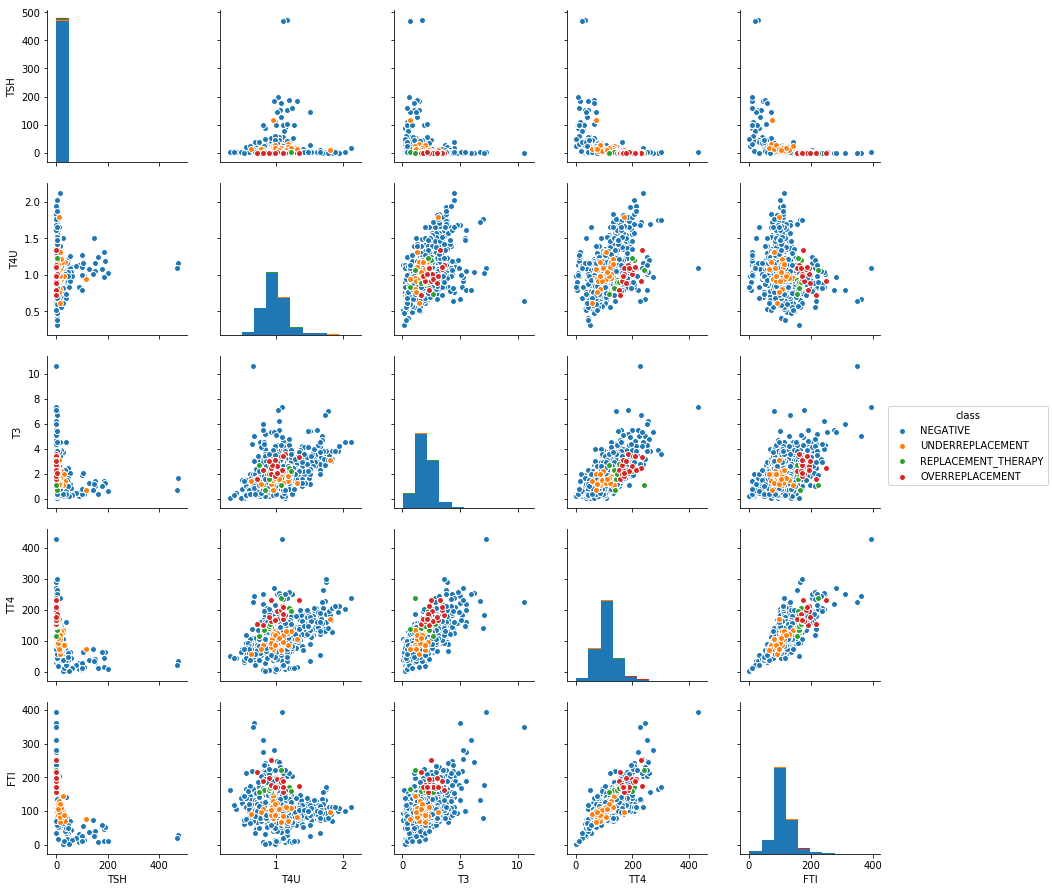

In [96]:
sample = data.dropna()
#seaborn.pairplot(sample.loc[:,['TSH', 'T4U', 'T3', 'TT4', 'unknown1']])
dataFrame = data.loc[:,['TSH', 'T4U', 'T3', 'TT4']]
dataFrame['FTI'] = pd.to_numeric(data['FTI'], errors='coerce')

column1_name = 'CLASS'

dataFrame['class'] = data['CLASS']
dataFrame = dataFrame.dropna()


seaborn.pairplot(dataFrame[dataFrame['class'] != 'negative'], dropna=True, hue='class')

In [162]:
data['CLASS'].value_counts()

NEGATIVE               2713
UNDERREPLACEMENT         35
REPLACEMENT_THERAPY      29
OVERREPLACEMENT          23
Name: CLASS, dtype: int64

In [594]:
df0 = data[(data['TSH'] < 0.2) & ((data['T4U'] < 1.1) & (data['T4U'] < 0.8))]
df0.shape

(44, 41)

In [595]:
df0['CLASS'].value_counts()

NEGATIVE               40
REPLACEMENT_THERAPY     3
OVERREPLACEMENT         1
Name: CLASS, dtype: int64

In [558]:
df1 = data[(data['FTI'] < 71) | (data['TT4'] < 72) | (data['T3'] > 3.6) | (data['T4U'] > 1.34)]
df1.shape

(420, 41)

In [559]:
df1['CLASS'].value_counts()

NEGATIVE            414
UNDERREPLACEMENT      6
Name: CLASS, dtype: int64

In [480]:
df2 = data[(data['T4U'] > 1.36)]

In [476]:
df2['CLASS'].value_counts()

NEGATIVE            111
UNDERREPLACEMENT      1
Name: CLASS, dtype: int64

In [265]:
df3 = data[(data['TSH'] > 80) | ((data['TSH'] < 1) & (data['T3'] > 3.6)) | ((data['TSH'] > 40) & (data['TSH'] < 75))]
df3.shape

(112, 41)

In [266]:
df3['CLASS'].value_counts()

NEGATIVE            111
UNDERREPLACEMENT      1
Name: CLASS, dtype: int64

In [386]:
df4 = data[(data['TSH'] < 37) & (data['T3'] > 3.4)]
df4.shape

(99, 41)

In [387]:
df4['CLASS'].value_counts()

NEGATIVE           98
OVERREPLACEMENT     1
Name: CLASS, dtype: int64

In [615]:
df5 = data[(data['FTI'] < 65)]
df5.shape

(90, 41)

In [616]:
df5['CLASS'].value_counts()

NEGATIVE    90
Name: CLASS, dtype: int64